In [1]:
import pandas as pd
import numpy as np

df_weight = pd.read_csv('df_weight')
df_weight.head()

,4-aminobenzoic acid,aclarubicin,adenosine triphosphate,alfentanil,aluminum hydroxide,mitomycin,ammonium chloride,belladonna alkaloids,boric acid,calcium phosphate,...,EYE,CONG,METAB,BLOOD,STAT,DEV,MENTAL,HEARING,ID,Label
0,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.029630
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.045685
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015936
3,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.102639
4,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.117073


In [4]:
#Catboost - my own hyperparameter search - improved!a - 30% Weight Loss catboost
#Here is the more final slightly more limited version
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.2 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    #print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc 




def catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs):
    cat_aucs = []
    params = []
    for dep in depths:
        for lr in learning_rates:
            for itr in iterations:
                for l2 in l2_leaf_regs:
                    X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, itr, 
                                                                                                lr, dep, l2)
                    cat_aucs.append(cat_auc)
                    params.append([dep, lr, itr, l2])


    print('max_auc: ', max(cat_aucs))
    cat_aucs = np.array(cat_aucs)
    print('best parameters: ', params[np.argmax(cat_aucs)])
    
    return params[np.argmax(cat_aucs)]

depths = [2,3,4,6]
learning_rates = [0.03, 0.1, 0.3, 0.5]
iterations = [50, 75, 100]
l2_leaf_regs = [0.5, 1, 5]

best_params = catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs)
    

max_auc:  0.7008814783347493
best parameters:  [2, 0.3, 75, 0.5]


Catboost: ROC AUC=0.701


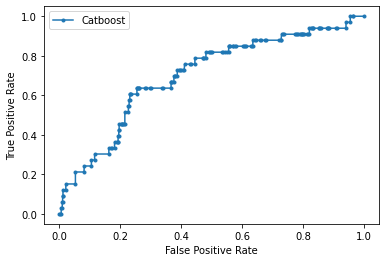

In [4]:
#20% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.2 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 75, 0.3, 2, 0.5)

AUROC: 0.701
95% CI: [0.698, 0.703]
Catboost: ROC AUC=0.701


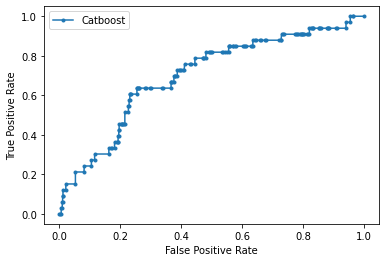

In [9]:
#20% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy.stats import sem, t

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.2 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)

    # Calculate the confidence interval using the t-distribution
    n = len(y_test)
    m = sem(cat_probs)
    h = m * t.ppf((1 + 0.95) / 2, n - 1)

    # Print the AUROC score and confidence interval
    print(f"AUROC: {cat_auc:.3f}")
    print(f"95% CI: [{cat_auc - h:.3f}, {cat_auc + h:.3f}]")
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 75, 0.3, 2, 0.5)

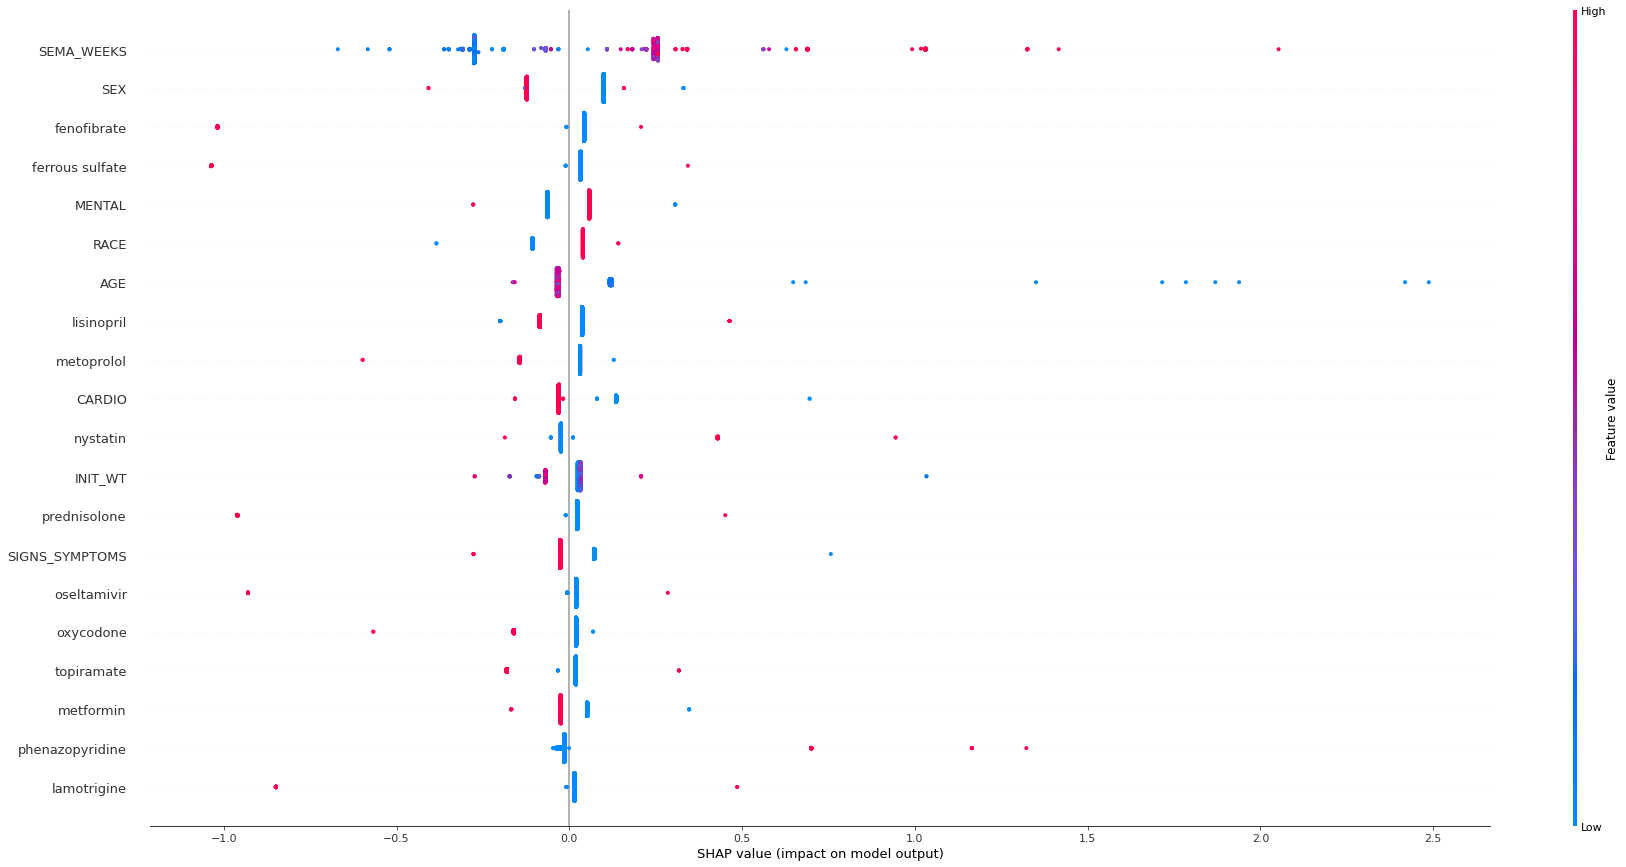

In [10]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
plt_shap = shap.summary_plot(shap_values, #Use Shap values array
                             features=X_train, # Use training set features
                             feature_names=X_train.columns, #Use column names
                             show=False, #Set to false to output to folder
                             title='Figure 4',
                             plot_size=(30,15)) # Change plot size

plt.savefig('figure4.png')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


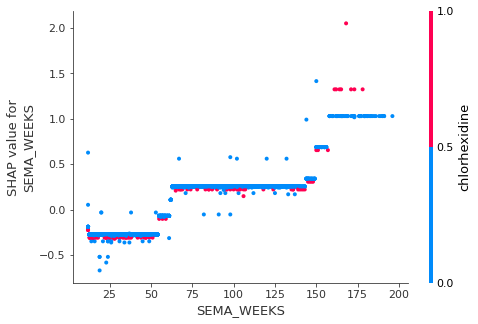

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


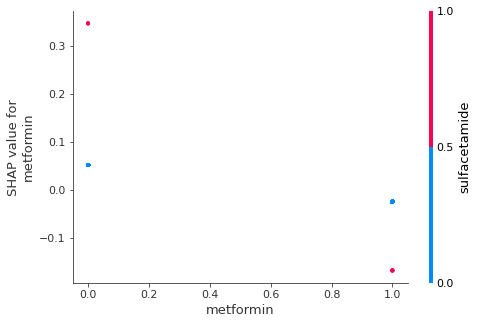

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


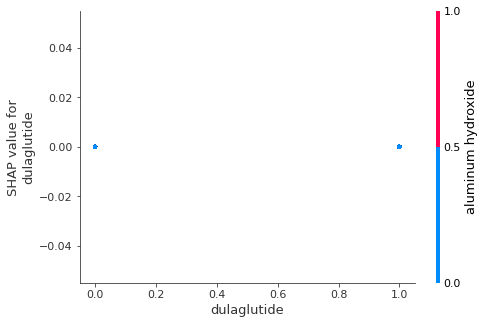

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


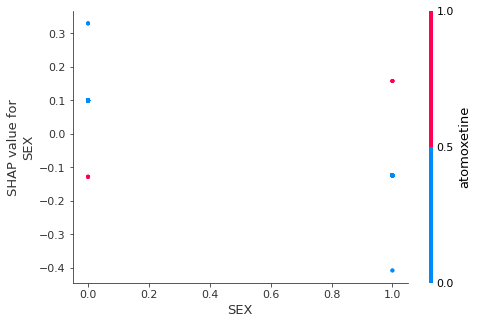

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


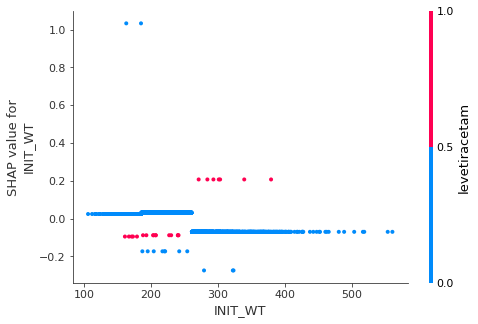

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


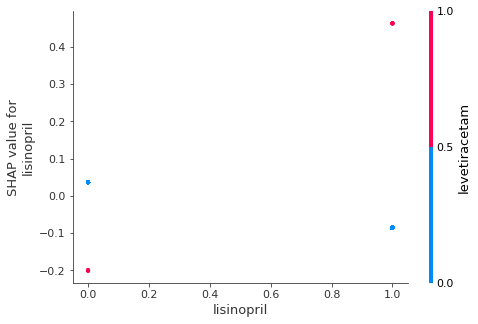

In [9]:
import shap
features = ['SEMA_WEEKS', 'metformin', 'dulaglutide', 'SEX',
            'INIT_WT', 'lisinopril']

for feature in features:
    shap.dependence_plot(feature, shap_values, X_train)

In [11]:
f = plt.gcf()
f.savefig('catboost_shap.png')

<Figure size 432x288 with 0 Axes>

In [5]:
'''
Implementing the Repeated Cross-Validations - 10%
'''
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import shap

def write_shap_dict(df_weight):
    '''
    Function to write the empty dictionary for the SHAP values
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    
    np.random.seed(31)
    CV_repeats = 10

    # Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
    random_states = np.random.randint(10000, size=CV_repeats) 

    #Dictionary to keep track of the SHAP values of each observation per CV repition
    shap_values_per_cv = {}
    for sample in X.index:
        #create keys for each sample
        shap_values_per_cv[sample] = {}
        #keys for each CV fold within each sample
        for CV_repeat in range(CV_repeats):
            shap_values_per_cv[sample][CV_repeat] = {}
            
    return shap_values_per_cv, random_states
            
shap_values_per_cv, random_states = write_shap_dict(df_weight)

def fit_catboost_cv(df_weight, dep, lr, itr, l2, shap_values_per_cv, random_states):
    '''
    Performing the Cross-Validation
    '''

    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y = pd.DataFrame(y)
    
    CV_repeats=10

    for i, CV_repeat in enumerate(range(CV_repeats)):
        #Verbose 
        print('\n------------ CV Repeat number:', CV_repeat)

        #Cross-Validations
        CV = KFold(n_splits=5, shuffle=True, random_state = random_states[i])
        ix_training, ix_test = [], []

        #Loop through the CV fold and put the train and test indices into the empty lists above
        for fold in CV.split(df_weight):
            ix_training.append(fold[0])
            ix_test.append(fold[1])
        
        #Loop through outer folds and extract SHAP values
        for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
            #Verbose
            print('\n------ Fold Number:',i)

            X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
            y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix] #Potential fix for the type of y here


            model = CatBoostClassifier(iterations=itr,
                                learning_rate=lr,
                                depth=dep, 
                                l2_leaf_reg = l2,
                                verbose=False)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
                
            # predict probabilities
            cat_probs = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            cat_probs = cat_probs[:, 1]
            
            # calculate scores
            cat_auc = roc_auc_score(y_test, cat_probs)

            # summarize scores
            print('Catboost: ROC AUC=%.3f' % (cat_auc))

            # Use SHAP to explain predictions
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # Extract SHAP information per fold per sample 
            for i, test_index in enumerate(test_outer_ix):
                shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
                
    return shap_values_per_cv

shap_values_per_cv = fit_catboost_cv(df_weight, 2, 0.3, 75, 0.5, shap_values_per_cv, random_states)  


------------ CV Repeat number: 0

------ Fold Number: 0
Catboost: ROC AUC=0.610

------ Fold Number: 1
Catboost: ROC AUC=0.585

------ Fold Number: 2
Catboost: ROC AUC=0.590

------ Fold Number: 3
Catboost: ROC AUC=0.588

------ Fold Number: 4
Catboost: ROC AUC=0.576

------------ CV Repeat number: 1

------ Fold Number: 0
Catboost: ROC AUC=0.574

------ Fold Number: 1
Catboost: ROC AUC=0.562

------ Fold Number: 2
Catboost: ROC AUC=0.579

------ Fold Number: 3
Catboost: ROC AUC=0.601

------ Fold Number: 4
Catboost: ROC AUC=0.580

------------ CV Repeat number: 2

------ Fold Number: 0
Catboost: ROC AUC=0.568

------ Fold Number: 1
Catboost: ROC AUC=0.623

------ Fold Number: 2
Catboost: ROC AUC=0.576

------ Fold Number: 3
Catboost: ROC AUC=0.562

------ Fold Number: 4
Catboost: ROC AUC=0.625

------------ CV Repeat number: 3

------ Fold Number: 0
Catboost: ROC AUC=0.592

------ Fold Number: 1
Catboost: ROC AUC=0.581

------ Fold Number: 2
Catboost: ROC AUC=0.570

------ Fold Numbe

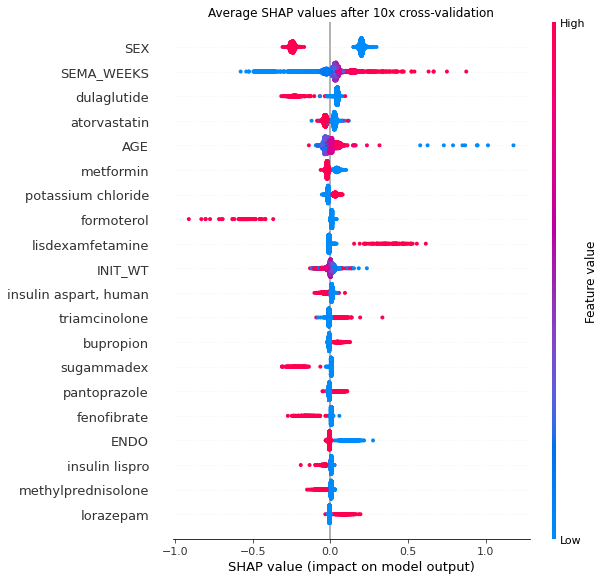

In [6]:
'''
Getting the Shap Plots of the average values from the Cross-Validations
'''
X = df_weight.iloc[:,:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
y = pd.DataFrame(y)
    
average_shap_values, stds, ranges = [], [], []

for i in range(0, len(df_weight)):
    # Get all SHAP values for sample number i
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) 
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)


shap.summary_plot(np.array(average_shap_values), X, show = False)
plt.title('Average SHAP values after 10x cross-validation')
plt.savefig('catboost_cv_shap.png')

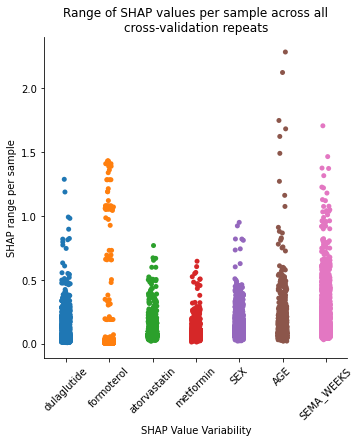

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ranges = pd.DataFrame(ranges)
ranges.columns = X.columns

# Transpose dataframe to long form
values, labels = [],[]
for i in range(len(ranges.columns)):
    for j in range(len(ranges)):
        values.append(ranges.T[j][i])
        labels.append(ranges.columns[i])
long_df = pd.DataFrame([values,labels]).T ; long_df.columns = ['Values', 'Features']

shap_features = ['SEX', 'SEMA_WEEKS', 'dulaglutide', 'atorvastatin', 'AGE',
                'metformin', 'formoterol']
long_df = long_df[long_df['Features'].isin(shap_features)]

title = 'Range of SHAP values per sample across all\ncross-validation repeats'
xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                            title = title)
plt.xticks(rotation=45)
plt.savefig('SHAP_range.png')

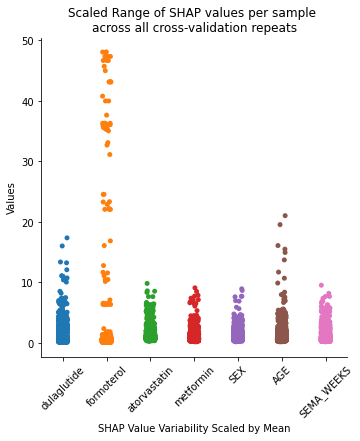

In [ ]:
'''
The standardized Shapley Ranges Plot
'''
long_df['Values'] = pd.to_numeric(long_df['Values'], downcast='float')
mean_abs_effects = long_df.groupby(['Features']).mean()

standardized = long_df.groupby(long_df.Features).transform(lambda x: x/x.mean()) ; standardized['Features'] = long_df.Features

title = 'Scaled Range of SHAP values per sample \nacross all cross-validation repeats'
sns.catplot(data = standardized, x = 'Features', y = 'Values').set(xlabel = 'SHAP Value Variability Scaled by Mean', 
                                                                            title = title)
plt.xticks(rotation=45)
plt.savefig('SHAP_ranges_standardized.png')

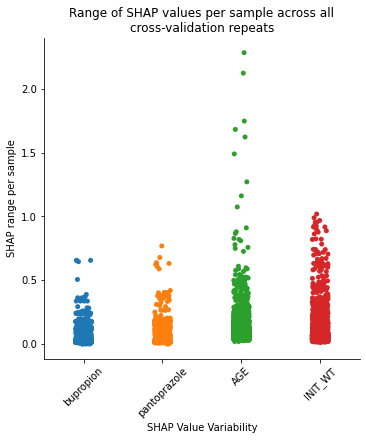

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ranges = pd.DataFrame(ranges)
ranges.columns = X.columns

# Transpose dataframe to long form
values, labels = [],[]
for i in range(len(ranges.columns)):
    for j in range(len(ranges)):
        values.append(ranges.T[j][i])
        labels.append(ranges.columns[i])
long_df = pd.DataFrame([values,labels]).T ; long_df.columns = ['Values', 'Features']

shap_features = ['INIT_WT', 'AGE', 'bupropion', 'pantoprazole']
long_df = long_df[long_df['Features'].isin(shap_features)]

title = 'Range of SHAP values per sample across all\ncross-validation repeats'
xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                            title = title)
plt.xticks(rotation=45)
plt.savefig('SHAP_range.png')

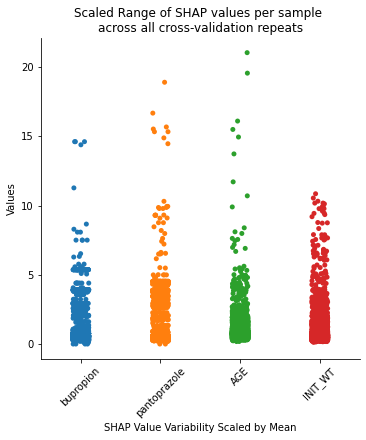

In [8]:
'''
The standardized Shapley Ranges Plot
'''
long_df['Values'] = pd.to_numeric(long_df['Values'], downcast='float')
mean_abs_effects = long_df.groupby(['Features']).mean()

standardized = long_df.groupby(long_df.Features).transform(lambda x: x/x.mean()) ; standardized['Features'] = long_df.Features

title = 'Scaled Range of SHAP values per sample \nacross all cross-validation repeats'
sns.catplot(data = standardized, x = 'Features', y = 'Values').set(xlabel = 'SHAP Value Variability Scaled by Mean', 
                                                                            title = title)
plt.xticks(rotation=45)
plt.savefig('SHAP_ranges_standardized.png')

Matplotlib is building the font cache; this may take a moment.


Catboost: ROC AUC=0.701


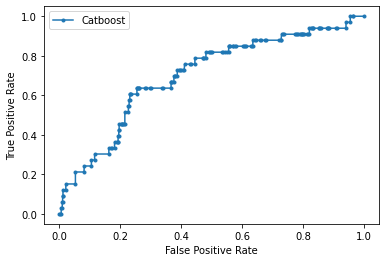

(0, 1)


/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in double_scalars


In [3]:
#20% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from math import sqrt

def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.2 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    CI = roc_auc_ci(y_test, cat_probs)
    
    return X_train, X_test, y_train, y_test, model, cat_auc, CI


X_train, X_test, y_train, y_test, model, cat_auc, CI = fit_catboost_classifier4(df_weight, 75, 0.3, 2, 0.5)

print(CI)



In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X = df_weight.iloc[:,:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y_binary = [1 if a<-.2 else 0 for a in df_weight.iloc[:,-1]]
y_binary = pd.DataFrame(y_binary)

# y_test and y_pred are assumed to be numpy arrays or pandas series
tn, fp, fn, tp = confusion_matrix(y_binary, model.predict(X)).ravel()

# calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(accuracy_score(y_binary, model.predict(X)))

Sensitivity: 0.15384615384615385
Specificity: 0.9997102289191538
0.9749648382559775


In [2]:
pip install catboost

     |████████████████████████████████| 76.6 MB 289 kB/s             
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
